# How to Benchmark Optimization Algorithms

Benchmarking optimization algorithms is an important step when developing a new algorithm or when searching for a algorithm that is good at solving a particular problem. 

In general, benchmarking constists of the following steps:

- Defining the test problems (or getting pre-implemented ones)
- Defining the optimization algorithms and the tuning parameters you want to try
- Running the benchmark
- Plotting the results. 

## Get Test Problems

Estimagic includes the problems of [Moré and Wild (2009)](https://epubs.siam.org/doi/pdf/10.1137/080724083) by default.

Each problem consist of the `inputs` (the criterion function and the start parameters) and the `solution` (the optimal parameters and criterion value).

Below we load the Moré and Wild problems and look at one Rosenbrock problem with difficult start parameters.

In [1]:
from estimagic import get_benchmark_problems

problems = get_benchmark_problems("example")

## Specifying the Optimizers

An optimizer consists of the algorithm name and its `algo_options`. 

Below, we compare a strict version of the L-BFGS-B with all available algorithms at their default.

In [3]:
optimizers = [
    "scipy_lbfgsb",
    "scipy_neldermead",
    "scipy_truncated_newton",
]

## Running the Benchmark

Once you have your problems and your optimizers, you can simply use `run_benchmark`. The results are a dictionary with one entry for each (problem, algorithm) combination. Each entry not only saves the the solution but also the history of the algorithm's criterion and parameter history. 

In [4]:
from estimagic import run_benchmark

results = run_benchmark(
    problems,
    optimizers,
    logging_directory="benchmark_logs",
    n_cores=4,
)

## Visualizing the Results

Once you have your results, you can easily visualize the results. 

estimagic provides two types of plots: Convergence Plots and Data Profile Plots. 
Each serves a different purpose. 

To see how optimizers fared on particular problems, the **Convergence Plots** are useful. They are similar to the convergence plots you know from the dashboard but show you the trajectories of different optimizers in one plot. 

To compare optimizers over the whole problem set, use the **Data Profile Plots** proposed by [Moré and Wild (2009)](https://epubs.siam.org/doi/pdf/10.1137/080724083). 

We show how to create each plot and explain how to interpret them below.

### Convergence Plots for Comparing Optimizers 

Below we show how fast different optimizers converged on a few of our problems. 

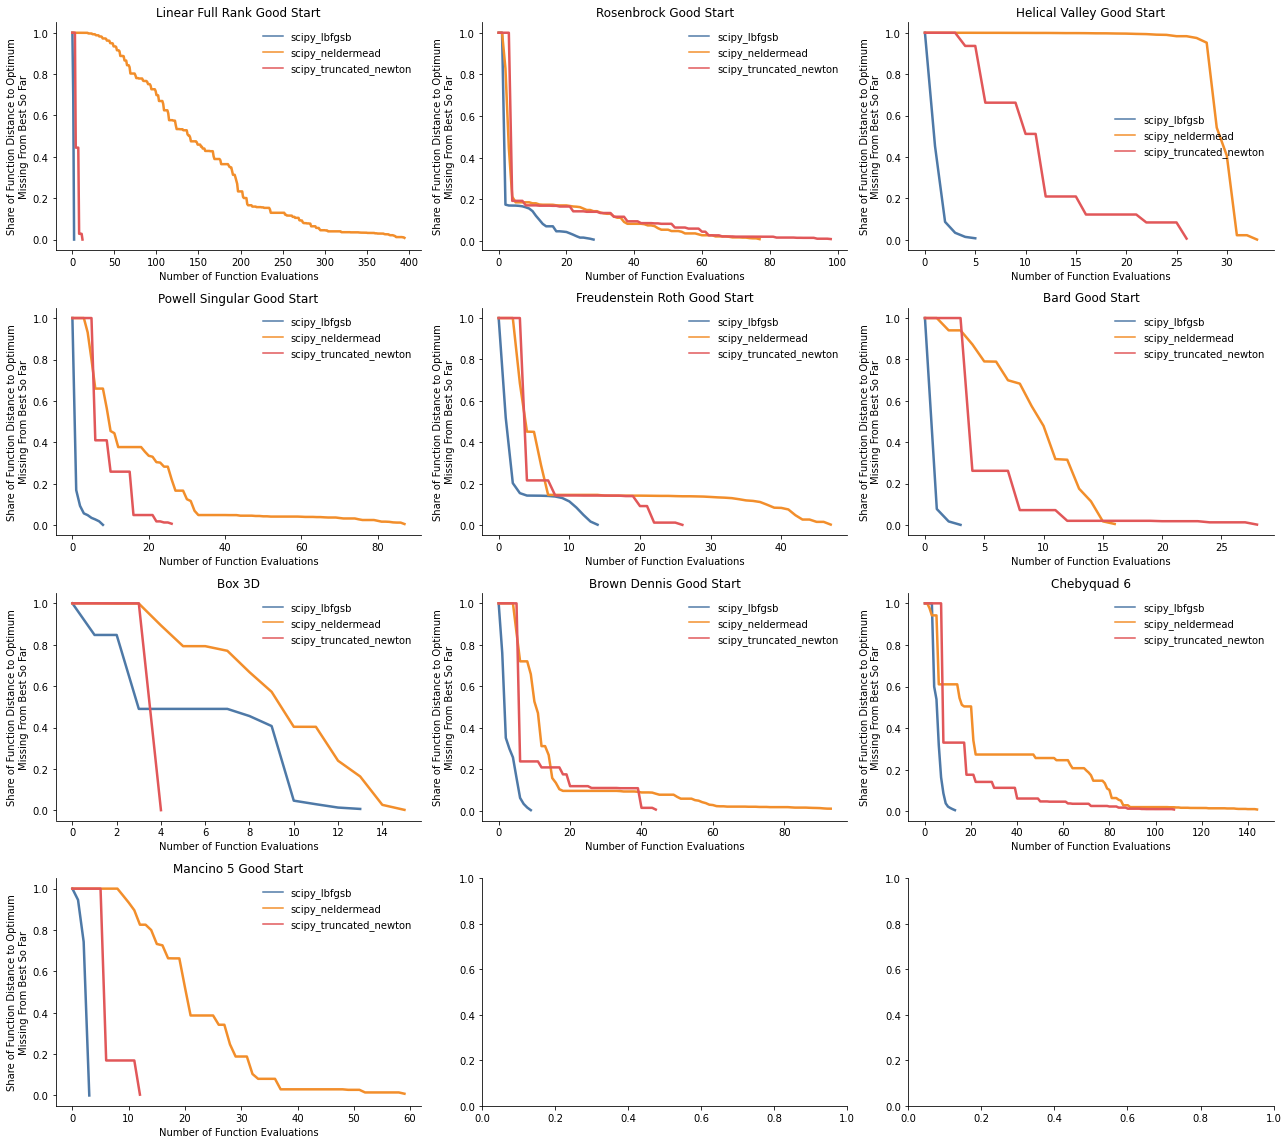

In [5]:
import numpy as np

from estimagic import convergence_plot

fig, axes = convergence_plot(
    problems=problems,
    results=results,
    n_cols=3,
    distance_measure="criterion",
    runtime_measure="n_evaluations",
    stopping_criterion="y",
    y_precision=0.01,
)

The first thing that stands out is that L-BFGS-B strongly outperforms Nelder-Mead on every problem we are looking at.

The second thing we can observe is that the two L-BFGS-B optimizers lie exactly on top of each other. This is not very surprising because our required precision (99% of the distance from the start to the target criterion value must be covered by the optimizer) here is quite large. Therefore, the standard L-BFGS-B algorithm already terminates after it is sufficiently close to the true solution and the two lines are exactly 

### Comparing Optimizer Performance Over the Whole Problem Set

Data profiles answer the question: What percentage of problems can each algorithm solve within a certain runtime budget relative to the best algorithm on each problem?

The runtime budget is plotted on the x axis and given in multiples of the best
performing algorithm's required runtime to solve each problem.

Below you can see the for the different optimizers on our problem set:

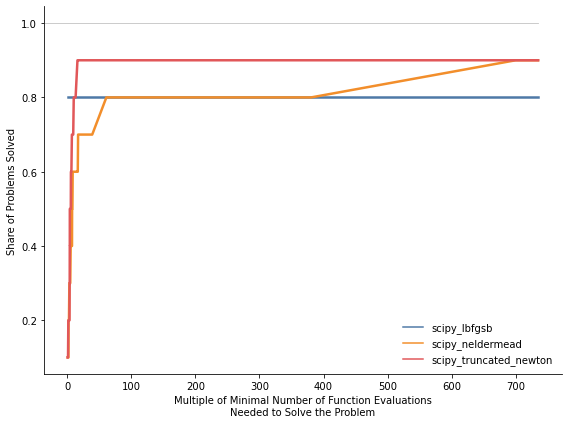

In [6]:
from estimagic.visualization.profile_plot import profile_plot

fig, ax = profile_plot(
    problems=problems,
    results=results,
    runtime_measure="n_evaluations",
    y_precision=1e-10,
)

#### How to Interpret the Data Profile Plot

Aggregating over all problems, we can see that the pattern we saw in the Convergence Plots holds more generally: L-BFGS-B strongly outperforms Nelder-Mead. Only being willing to wait 3000 times the fastest algorithm's 

However, there are some problems which neither L-BGFS-B nor Nelder-Mead can solve since neither of them reaches 1.0. 

Let's look at a table giving us their performance, to explore which problems these are:

In [7]:
from estimagic.benchmarking.process_benchmark_results import create_performance_df

df, converged_info = create_performance_df(
    problems=problems,
    results=results,
    stopping_criterion="y",
    y_precision=1e-3,
    x_precision=None,
)

converged_info  # [~converged_info.all(axis=1)]

algorithm,scipy_lbfgsb,scipy_neldermead,scipy_truncated_newton
problem,,,
bard_good_start,True,True,True
box_3d,True,True,True
brown_dennis_good_start,True,True,True
chebyquad_6,True,True,True
freudenstein_roth_good_start,True,True,True
helical_valley_good_start,True,True,True
linear_full_rank_good_start,True,True,True
mancino_5_good_start,True,True,True
powell_singular_good_start,True,True,True


Looking at the info on convergence we can see that there are two problems (*freudenstein_roth_good_start* and *osborne_two_bad_start*) which no optimizer was able to solve. L-BFGS-B alone solved *brown_almost_linear_medium* and only Nelder-Mead was able to solve *jennrich_sampson* and *osborne_one* which is why it was able to overtake  L-BFGS-B on the very right in the data profile plot above. 